In [1]:
def determine(lst):
    return (all(x == 0.0 for x in lst))

def check_zeros(data):
    new_data = []
    for i in data:
        if not determine(i[1]):
            if new_data == None:
                new_data = i
            else:
                new_data.append(i)
    return new_data


def merge_dataframe(df1, df2, column_names):
    final_df = df1
    return final_df.join(df2[column_names].set_index('pid'), on='pid', how='inner')


#get all the data from a specific order
def get_data_order(data, order_name):
    new_data = []

    if (order_name == 'coleoptera'):
        index_one = 0
    elif (order_name == 'diptera'):
        index_one = 1
    elif (order_name == 'hymenoptera'):
        index_one = 2
    elif (order_name == 'lepidoptera'):
        index_one = 3
    
    for i in range(len(data)):
        code_order = data[i][2][index_one]
        if(code_order == 1):
            data[i][2] = [1,0]
        else:
            data[i][2] = [0,1]
        new_data.append(data[i])
            
    return new_data

def read_pids_fasta(file_fasta):
    pids = []
    for record in SeqIO.parse(file_fasta, "fasta"):
        record_id = record.id
        pids.append(record_id.split("|")[0])        
    return pids

def save_object(obj, filename):
    with open(filename, 'wb') as output:  
        pickle.dump(obj, output, protocol=2)
        
def split_new(data,training_percent):
    training_percent = float(training_percent)
    for i in range(len(data)):
        if i < int(len(data)*training_percent):
            data[i].append(['train'])
        else:
            data[i].append(['test'])
    return data
    
def split(feature_file,training_percent):

    training_percent = float(training_percent)
    
    with open("../feature_data/" + feature_file, 'rb') as file:
        data = pickle.load(file)
        for i in range(len(data)):
            if i < int(len(data)*training_percent):
                data[i].append(['train'])
            else:
                data[i].append(['test'])
        return data
        #save_object(data, "train_and_test/tt-" + str(training_percent) + "-" + feature_file)

def build_DNN(train_x,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net = tflearn.input_data(shape=[None, len(train_x[0])])
    # Two fully connected layers with 8 hidden units/neurons - optimal for this task
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, 4,activation='softmax')
    # number of intents, columns in the matrix train_y
    #net = tflearn.fully_connected(net, len(train_y[0]), activation='softmax')
    # regression to find best parameters, during training
    net = tflearn.regression(net)

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_sequence_logs')
    return modell

def build_DNN_Arch1(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
    net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch1_logs', tensorboard_verbose=3)
    return model

def build_DNN_Arch2(aa_length, nu_length,train_y):
    tf.reset_default_graph()
    # Build neural network - input data shape, number of words in vocabulary (size of first array element). 
    net_aa = tflearn.input_data(shape=[None, aa_length], name="InputData0")
    net_nu = tflearn.input_data(shape=[None, nu_length], name="InputData1")
    # Two fully connected layers with 8 hidden units/neurons
#     net_aa = tflearn.fully_connected(net_aa, 4)
    net_nu = tflearn.fully_connected(net_nu, 4)
    # number of intents, columns in the matrix train_y
    net = tflearn.merge_outputs([net_aa, net_nu])
    net = tflearn.fully_connected(net, 4)
    net = tflearn.fully_connected(net, len(train_y[0]), activation='sigmoid')
    # regression to find best parameters, during training
    net = tflearn.regression(net, optimizer='adam')

    # Define Deep Neural Network model and setup tensorboard
    model = tflearn.DNN(net, tensorboard_dir='tflearn_arch2_logs', tensorboard_verbose=3)
    return model

def train_DNN(model, train_x,train_y,classes):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model.fit(train_x, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save('model/'+classes[0]+'_'+classes[1]+'.tflearn')

def train_DNN_arch12(model, train_aa, train_nu, train_y,classes,arch):
    # Start training (apply gradient descent algorithm)
    # n_epoch - number of epoch to run
    # Batch size defines number of samples that going to be propagated through the network.
    model_name = 'model/'+classes+'_'+arch+'.tflearn'
    model.fit({"InputData0":train_aa,"InputData1":train_nu}, train_y, n_epoch=5, batch_size=5, show_metric=True)
    model.save(model_name)
    return model_name

def predict_old(frequency,model,classes):

    ERROR_THRESHOLD = 0.5
    
    # generate probabilities from the model
    results = model.predict(frequency)[0]

    # filter out predictions below a threshold, and provide intent index
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append(classes[r[0]])
    
    return return_list

def predict(model, test_aa, test_nu,classes):
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]

    new_results = results
    if results[0] > results[1]:
        #new_results[0] = results[0]
        #new_results[1] = results[1]
        class_result = 0
    else:
        #new_results[0] = results[1]
        #new_results[1] = results[0]
        class_result = 1

    #return_list = []
    #return_list.append((classes[class_result], str(new_results[0])))
    return classes[class_result], results[0]

def predict_with_threshold(model, test_aa, test_nu,classes):
    
    THRESHOLD = 0.5
        
    results = model.predict({"InputData0":[test_aa],"InputData1":[test_nu]})[0]
    
    if(results[0] >= THRESHOLD):
        class_index = 0 #The first class is the positive class
    else:
        class_index = 1 

    return classes[class_index], results[0]

def fix_format(string):
    return re.sub('[\[\]\']','',string)

def plot_roc(y_test,y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = array(y_test)
    y_score = array(y_score)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def metrics_DNN(predict_y,id_test,test_y,classes,scores):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    id_misclassified = []
    pred_misclassified = []
    y_misclassified = []
    all_pred = []
    all_y = []
    
    #class[0] is the positive class, test_y == 1 is the positive class
    for i in range(len(predict_y)):
        #True positive
        if (predict_y[i] == classes[0] and test_y[i] == 1):
            true_positive += 1
            all_pred.append(classes[0])
            all_y.append(classes[0])
        #
        elif (predict_y[i] == classes[1] and test_y[i] == 0):
            true_negative += 1
            all_pred.append(classes[1])
            all_y.append(classes[1])
        elif(predict_y[i] == classes[1] and test_y[i] == 1):
            false_negative += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[0])
            all_pred.append(classes[1])
            all_y.append(classes[0])
        elif(predict_y[i] == classes[0] and test_y[i] == 0):
            false_positive += 1
            pred_misclassified.append(predict_y[i])
            id_misclassified.append(id_test[i])
            y_misclassified.append(classes[1])
            all_pred.append(classes[0])
            all_y.append(classes[1])
        
    df_all = pd.DataFrame({'id': id_test, 'predicted': all_pred, 'real_class': all_y})
    df_misclassified = pd.DataFrame({'id': id_misclassified,'predicted': pred_misclassified,'real_class': y_misclassified})
            
    precision_classe0 = float(true_positive)/(true_positive + false_positive)
    sensitivity = float(true_positive)/(true_positive + false_negative) #recall for class0
    F1_score_class0 = 2*(float(precision_classe0*sensitivity)/(precision_classe0 + sensitivity))
    
    precision_classe1 = float(true_negative)/(true_negative + false_negative)
    specificity = float(true_negative)/(false_positive + true_negative)#recall for class1
    F1_score_class1 = 2*(float(precision_classe1*specificity)/(precision_classe1 + specificity))
    
    accuracy = float(true_positive + true_negative)/len(predict_y)
    
    print("Class " + classes[0] +":")
    print("Precision: " + str(precision_classe0))
    print("Sensitivity: " + str(sensitivity))
    print("F1 score: " + str(F1_score_class0))
    
    print("")
    
    print("Class " + classes[1] +":")
    print("Precision: " + str(precision_classe1))
    print("Specificity: " + str(specificity))
    print("F1 score: " + str(F1_score_class1))
    
    print("")
    
    print("Accuracy:")
    print(accuracy)

    plot_roc(test_y,scores)
    
    return df_all

In [2]:
import numpy as np
import tflearn
import tensorflow as tf
from random import shuffle
import pickle
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score
import argparse
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from numpy import array
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


# Data preparation

In [3]:
final_df = None
count = 0
classes = ['coleoptera', 'not_coleoptera']
for i in range(0,6):
    i = str(i)
    nuc_filename = "ensemble_data/%snucblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl" % (i)
    amino_filename = "ensemble_data/%saminoblock-235-mer-top-10coleopteradipterahymenopteralepidoptera-ratio.pkl" % (i)
    nuc_x_name = 'ndata_x%s' % (i)
    amino_x_name = 'adata_x%s' % (i)
    final_df_name = 'final_df_%s' % (i)
    with open(nuc_filename, 'rb') as file:
        nuc_data = pickle.load(file)
        shuffle(nuc_data)
        nuc_data = get_data_order(nuc_data, classes[0])
        nuc_data = pd.DataFrame(data = nuc_data, columns=['pid', nuc_x_name, 'data_y'])
    with open(amino_filename, 'rb') as file:
        amino_data = pickle.load(file)
        shuffle(amino_data)
        amino_data = get_data_order(amino_data, classes[0])
        amino_data = pd.DataFrame(data = amino_data, columns=['pid', amino_x_name, 'data_y'])
    each_df = merge_dataframe(nuc_data, amino_data, ['pid', amino_x_name])
    if count == 0:
        final_df = each_df
    else:
        final_df = merge_dataframe(final_df, each_df, ['pid', amino_x_name, nuc_x_name])
    count += 1

In [4]:
nuc_all_df = None
amino_all_df = None
for i in range(0,6):
    nuc_x_name = 'ndata_x%s' % (i)
    amino_x_name = 'adata_x%s' % (i)
    if nuc_all_df is None:
        nuc_all_df = final_df[nuc_x_name]
    else:
        nuc_all_df += final_df[nuc_x_name] 
    if amino_all_df is None:
        amino_all_df = final_df[amino_x_name]
    else:
        amino_all_df += final_df[amino_x_name]
    final_df = final_df.drop([nuc_x_name], axis=1)
    final_df = final_df.drop([amino_x_name], axis=1)
final_df['nuc_all'] = nuc_all_df
final_df['amino_all'] = amino_all_df

In [5]:
final_df.head()

pid  data_y                                            nuc_all  \
1    ASNOR1782-11  [0, 1]  [0.0, 0.0103092784, 0.0515463918, 0.0618556701...   
5     JSCOL055-11  [1, 0]  [0.0, 0.0103092784, 0.0206185567, 0.0618556701...   
10    CNBPO199-13  [0, 1]  [0.0103092784, 0.0103092784, 0.0103092784, 0.0...   
11  GBMIN29474-13  [0, 1]  [0.0, 0.0, 0.0206185567, 0.1134020619, 0.02061...   
13    PHTCH365-08  [0, 1]  [0.0, 0.0, 0.0103092784, 0.0515463918, 0.02061...   

                                            amino_all  
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
5   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
13  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

# Train and Test split

In [6]:
nu_list = final_df[['pid', 'nuc_all','data_y']].values.tolist()
aa_list = final_df[['pid', 'amino_all','data_y']].values.tolist()
nu_list = split_new(nu_list,0.1)
aa_list = split_new(aa_list,0.1)

In [7]:
pid_label = 0
index_x = 1
index_y = 2
index_label = 3
train_aa_x = [] 
train_nu_x = []
data_y_train = [] 
for i in range(len(nu_list)):
    if ((nu_list[i][index_label][0]) == 'train'):
        train_nu_x.append(nu_list[i][index_x])
        data_y_train.append(nu_list[i][index_y])
for i in range(len(aa_list)):
    if ((aa_list[i][index_label][0]) == 'train'):
        train_aa_x.append(aa_list[i][index_x])

# Train

In [37]:
%%time
#Train

#build architecture
model = build_DNN_Arch1(len(train_aa_x[0]), len(train_nu_x[0]),data_y_train)
#train
model_name = train_DNN_arch12(model, train_aa_x, train_nu_x, data_y_train,classes[0],'1')

Training Step: 12499  | total loss: 0.00334 | time: 8.440s
| Adam | epoch: 005 | loss: 0.00334 - acc: 0.9976 -- iter: 12495/12500
Training Step: 12500  | total loss: 0.00305 | time: 8.443s
| Adam | epoch: 005 | loss: 0.00305 - acc: 0.9978 -- iter: 12500/12500
--
INFO:tensorflow:/Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/hymenoptera_1.tflearn is not in all_model_checkpoint_paths. Manually adding it.
CPU times: user 1min 10s, sys: 12.4 s, total: 1min 23s
Wall time: 1min 2s


# Test

In [8]:
#Get data for test
data_y_test = []
id_test = []        
test_aa_x = [] 
test_nu_x = []
for i in range(len(nu_list)):
    if ((nu_list[i][index_label][0]) == 'test'):
        test_nu_x.append(nu_list[i][index_x])
        data_y_test.append(nu_list[i][index_y])
        id_test.append(nu_list[i][pid_label])
for i in range(len(aa_list)):
    if ((aa_list[i][index_label][0]) == 'test'):
        test_aa_x.append(aa_list[i][index_x])


In [9]:
for i in data_y_test:
    if i != [1,0] and i != [0,1]:
        print(i)

In [40]:
%%time
import pandas as pd
#TEST

model = build_DNN_Arch1(len(train_aa_x[0]), len(train_nu_x[0]),data_y_train)
model.load(model_name)
result = []
scores = []
for i in range(len(test_aa_x)):
    cls, score = predict(model, test_aa_x[i], test_nu_x[i],classes)
    result.append(cls)
    scores.append(float(score))
    
df = pd.DataFrame(result)
df.columns = ['order']

INFO:tensorflow:Restoring parameters from /Users/jennyyu/Documents/sequence_classification/ensemble_classifiers/model/hymenoptera_1.tflearn
CPU times: user 1min 12s, sys: 9.51 s, total: 1min 22s
Wall time: 1min 3s


In [41]:
tes_first_neuron = [item[0] for item in data_y_test]

# Metrics

Class hymenoptera:
Precision: 0.9922192384493562
Sensitivity: 0.9784749100291981
F1 score: 0.9852991452991453

Class not_hymenoptera:
Precision: 0.9967645798036294
Specificity: 0.9988442735287499
F1 score: 0.9978033430054355

Accuracy:
0.9961778117527844


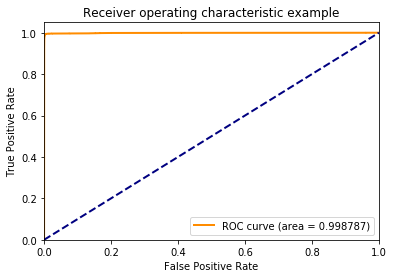

In [42]:
#Metrics
predict_data = df


# predict_data['order'] = [fix_format(x) for x in predict_data['order']]

#function that calculate all metrics

df_all = metrics_DNN(predict_data['order'],id_test,tes_first_neuron,classes,scores)

In [43]:
df_all.to_csv('output_data/'+'6_all_data_'+classes[0]+'.tsv',index=False,sep='\t')


In [15]:
print(len(final_df))

125001
